# 3‑D Palletisation — NumPy Baseline Notebook
This notebook contains **everything you need** to run and spectate the non‑reinforcement‑learning baselines for the pallet‑packing project:

1. The custom **Gym environment** (`Pallet3DBoxEnv`).
2. A simple **greedy height‑map heuristic**.
3. A **supervised imitation MLP** (pure NumPy).
4. Utilities to generate expert data, train, benchmark and visualise.

You can run the notebook top‑to‑bottom and modify the hyper‑parameters (e.g. number of training episodes) as you like.

## 0  Setup
Install or import the required libraries. Only **NumPy** is used for the algorithms; **gym** and **matplotlib** are needed for the environment and rendering.

In [4]:
!pip -q install gym==0.26.2 matplotlib tqdm --upgrade --quiet

## 1  Environment definition
The cell below defines the `Pallet3DBoxEnv` exactly as provided.

Step 1: Action 17, Reward 8
Step 2: Action 7, Reward 4
Step 3: Action 18, Reward 2
Step 4: Action 17, Reward 1
Step 5: Action 4, Reward 2
Step 6: Action 20, Reward -1
Step 7: Action 4, Reward -1
Step 8: Action 3, Reward -1
Step 9: Action 17, Reward -1
Step 10: Action 23, Reward -1
Step 11: Action 3, Reward 1
Step 12: Action 15, Reward 2
Step 13: Action 2, Reward 1
Step 14: Action 12, Reward -1
Step 15: Action 21, Reward -1
Step 16: Action 1, Reward -1
Step 17: Action 12, Reward -1
Step 18: Action 5, Reward 2
Step 19: Action 23, Reward -1
Step 20: Action 13, Reward -1
Step 21: Action 13, Reward 1
Step 22: Action 14, Reward -1
Step 23: Action 22, Reward -1
Step 24: Action 4, Reward -1
Step 25: Action 16, Reward 1
Step 26: Action 5, Reward -1
Step 27: Action 18, Reward -1
Step 28: Action 0, Reward -1
Step 29: Action 15, Reward -1
Step 30: Action 14, Reward -1
Step 31: Action 3, Reward -1
Step 32: Action 11, Reward -1
Step 33: Action 15, Reward -1
Step 34: Action 16, Reward -1
Step 35: Act

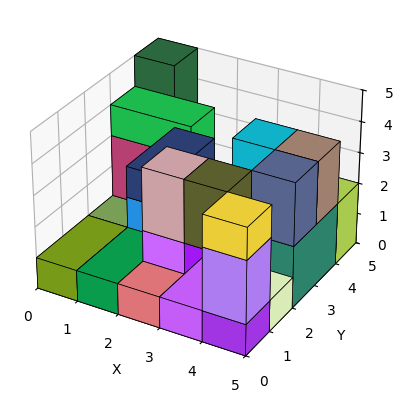

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 881  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.023326695 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.2        |
|    explained_variance   | -0.00678    |
|    learning_rate        | 0.001       |
|    loss                 | 2.02        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0641     |
|    value_loss           | 12.9        |
-----------------------------------------
-----------------

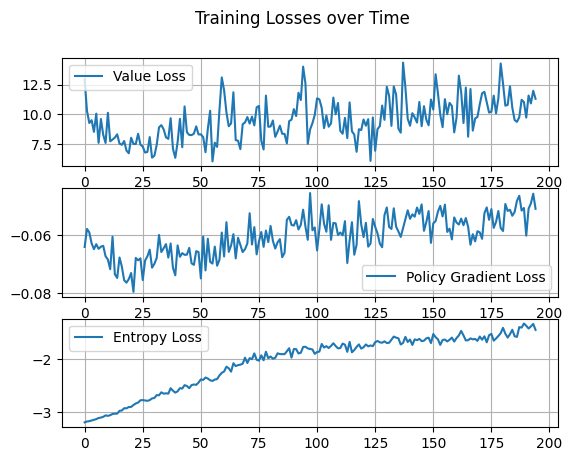

Step 1 | Action: 15 | Reward: 8
Step 2 | Action: 0 | Reward: 4
Step 3 | Action: 3 | Reward: 2
Step 4 | Action: 3 | Reward: 1
Step 5 | Action: 17 | Reward: 2
Step 6 | Action: 18 | Reward: 4
Step 7 | Action: 0 | Reward: 2
Step 8 | Action: 17 | Reward: 2
Step 9 | Action: 0 | Reward: 4
Step 10 | Action: 17 | Reward: 4
Step 11 | Action: 5 | Reward: 1
Step 12 | Action: 10 | Reward: 2
Step 13 | Action: 10 | Reward: 1
Step 14 | Action: 9 | Reward: 4
Step 15 | Action: 15 | Reward: 2
Step 16 | Action: 18 | Reward: 4
Step 17 | Action: 16 | Reward: 2
Step 18 | Action: 5 | Reward: -1
Step 19 | Action: 15 | Reward: 2
Step 20 | Action: 18 | Reward: 8
Step 21 | Action: 3 | Reward: 1
Step 22 | Action: 8 | Reward: -1
Step 23 | Action: 18 | Reward: 4
Step 24 | Action: 10 | Reward: -1
Step 25 | Action: 10 | Reward: 1
Step 26 | Action: 9 | Reward: 2
Step 27 | Action: 6 | Reward: 4
Step 28 | Action: 2 | Reward: -1
Step 29 | Action: 2 | Reward: -1
Step 30 | Action: 2 | Reward: -1
Step 31 | Action: 16 | Rewar

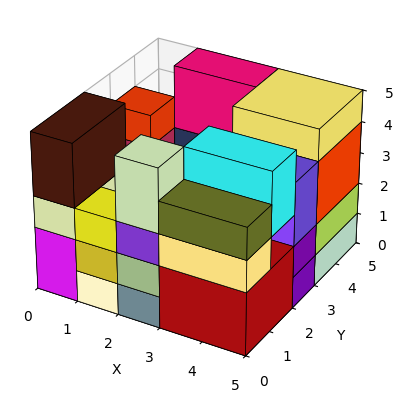

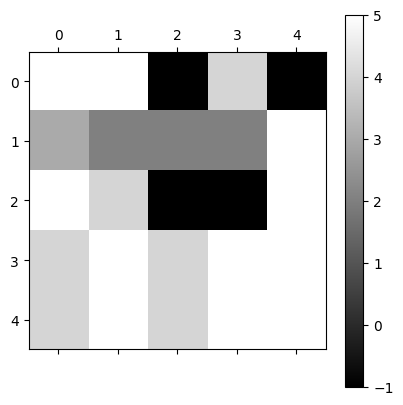

Number of non-placed boxes: 
Before training: 69
After training: 66
Volume of placed boxes: 
Before training: 58
After training: 88


In [5]:
# Code was mainly generated using generative AI tools
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
from stable_baselines3.common.callbacks import BaseCallback

class Box:
    def __init__(self, size, position=None):
        self.size = size  # (l, w, h)
        self.position = position  # (x, y, z), to be set when placed

    def set_position(self, pos):
        self.position = pos

    def get_bounds(self):
        x, y, z = self.position
        l, w, h = self.size
        return (x, x + l), (y, y + w), (z, z + h)

class Pallet3DBoxEnv(gym.Env):
    def __init__(self):
        super(Pallet3DBoxEnv, self).__init__()
        self.pallet_size = (5, 5, 5)
        self.n_boxes = 100

        pallet_dims = self.pallet_size[0] * self.pallet_size[1] * self.pallet_size[2]
        self.observation_space = spaces.Box(low=0, high=2, shape=(pallet_dims + 3,), dtype=np.int32)
        self.action_space = spaces.Discrete(self.pallet_size[0] * self.pallet_size[1])

        self.occupied = None
        self.placed_boxes = None
        self.box_queue = None
        self.current_box_idx = None

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.occupied = np.zeros(self.pallet_size, dtype=np.int32)
        self.placed_boxes = []
        self.current_box_idx = 0
        self.box_queue = [Box(tuple(random.choices([1, 2], k=3))) for _ in range(self.n_boxes)]

        return self._get_obs(), {}

    def _get_obs(self):
        flat_occupied = self.occupied.flatten()
        if self.current_box_idx < self.n_boxes:
            box = self.box_queue[self.current_box_idx]
        else:
            box = Box((0, 0, 0))
        box_info = np.array(box.size, dtype=np.int32)
        return np.concatenate([flat_occupied, box_info])

    def height_map(self):
        arr = test_env.occupied
        idx_matrix = np.argmax(np.flip(arr, axis=2), axis=2)
        has_ones = np.any(arr == 1, axis=2)

        # Flip indices back to correct order
        result = arr.shape[2] - idx_matrix

        # Set result to -1 where there are no ones
        result[~has_ones] = -1
        return result

    def is_valid_placement(self, box):
        (x1, x2), (y1, y2), (z1, z2) = box.get_bounds()

        # Bounds check
        if x2 > self.pallet_size[0] or y2 > self.pallet_size[1] or z2 > self.pallet_size[2]:
            return False

        # Collision check
        if np.any(self.occupied[x1:x2, y1:y2, z1:z2] != 0):
            return False

        # Must sit on floor or on another box
        if z1 == 0:
            return True
        return np.all(self.occupied[x1:x2, y1:y2, z1-1:z1] == 1)

    def step(self, action):
        if self.current_box_idx >= self.n_boxes:
            return self.occupied.copy(), 0, True, False, {}

        box = self.box_queue[self.current_box_idx]
        x = action // self.pallet_size[1]
        y = action % self.pallet_size[1]

        # Try to place at the lowest possible z
        placed = False
        for z in range(self.pallet_size[2]):
            box.set_position((x, y, z))
            if self.is_valid_placement(box):
                self.placed_boxes.append(box)
                (x1, x2), (y1, y2), (z1, z2) = box.get_bounds()
                self.occupied[x1:x2, y1:y2, z1:z2] = 1
                reward = box.size[0] * box.size[1] * box.size[2]  # reward = volume
                placed = True
                break

        if not placed:
            reward = -1  # failed to place

        self.current_box_idx += 1
        done = self.current_box_idx >= self.n_boxes

        return self._get_obs(), reward, done, False, {}



    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for box in self.placed_boxes:
            x, y, z = box.position
            l, w, h = box.size
            self._draw_box(ax, x, y, z, l, w, h)

        ax.set_xlim(0, self.pallet_size[0])
        ax.set_ylim(0, self.pallet_size[1])
        ax.set_zlim(0, self.pallet_size[2])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

    def _draw_box(self, ax, x, y, z, l, w, h):
        vertices = np.array([
            [x, y, z],
            [x + l, y, z],
            [x + l, y + w, z],
            [x, y + w, z],
            [x, y, z + h],
            [x + l, y, z + h],
            [x + l, y + w, z + h],
            [x, y + w, z + h]
        ])
        faces = [
            [vertices[j] for j in [0, 1, 2, 3]],
            [vertices[j] for j in [4, 5, 6, 7]],
            [vertices[j] for j in [0, 1, 5, 4]],
            [vertices[j] for j in [2, 3, 7, 6]],
            [vertices[j] for j in [1, 2, 6, 5]],
            [vertices[j] for j in [4, 7, 3, 0]]
        ]
        box = Poly3DCollection(faces, linewidths=0.5, edgecolors='k')
        box.set_facecolor(np.random.rand(3,))
        ax.add_collection3d(box)

class LossTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.loss_history = {
            'value_loss': [],
            'policy_gradient_loss': [],
            'entropy_loss': []
        }

    def _on_step(self) -> bool:
        # Required by BaseCallback
        return True

    def _on_rollout_end(self):
        logs = self.model.logger.name_to_value
        for key in self.loss_history.keys():
            if f"train/{key}" in logs:
                self.loss_history[key].append(logs[f"train/{key}"])

random.seed(0)
env = Pallet3DBoxEnv()
obs, _ = env.reset()

env_not_placed = 0
env_volume = 0 # the reward is volume for placed boxes. Otherwise, calculate using box parameters
for step in range(env.n_boxes):
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    if reward == -1: #!depends on reward
        env_not_placed += 1
    else:
        env_volume += reward
    print(f"Step {step+1}: Action {action}, Reward {reward}")
    if done:
        break

env.render()

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv


# Instantiate your environment
env = Pallet3DBoxEnv()

# Validate environment
check_env(env, warn=True)

# Wrap in DummyVecEnv for SB3 compatibility
vec_env = DummyVecEnv([lambda: Pallet3DBoxEnv()])

# Create PPO agent
model = PPO("MlpPolicy", vec_env, n_steps=1024, verbose=1, learning_rate= 0.001)

loss_cb = LossTrackingCallback()
# Train the agent
model.learn(total_timesteps=200000, callback=loss_cb)
# -------------------------------------------------------------------------
# Plot it after training
fig, ax = plt.subplots(3,1)
ax[0].plot(loss_cb.loss_history['value_loss'], label='Value Loss')
ax[0].legend()
ax[0].grid(True)
ax[1].plot(loss_cb.loss_history['policy_gradient_loss'], label='Policy Gradient Loss')
ax[1].legend()
ax[1].grid(True)
ax[2].plot(loss_cb.loss_history['entropy_loss'], label='Entropy Loss')
ax[2].legend()
ax[2].grid(True)
plt.suptitle("Training Losses over Time")
plt.show()

# -------------------------------------------------------------------------
# Run one full episode using the trained agent
random.seed(0)
test_env = Pallet3DBoxEnv()
obs, _ = test_env.reset()

test_env_not_placed = 0
test_env_volume = 0 # the reward is volume for placed boxes. Otherwise, calculate using box parameters
for step in range(test_env.n_boxes):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)
    print(f"Step {step+1} | Action: {action} | Reward: {reward}")
    if reward == -1: #!depends on reward
        test_env_not_placed += 1
    else:
        test_env_volume += reward
    if done:
        break

# Show 3D result
test_env.render()

result = test_env.height_map()
plt.matshow(result, cmap = "gray")
plt.colorbar()
plt.show()


print("Number of non-placed boxes: ")
print("Before training: " + str(env_not_placed))
print("After training: " + str(test_env_not_placed))
print("Volume of placed boxes: ")
print("Before training: " + str(env_volume))
print("After training: " + str(test_env_volume))




## 2  Helper‑functions and Greedy baseline

In [14]:
import numpy as np
import random, time, math
from tqdm import tqdm

# ---------- Corrected height-map helper ----------

def height_map(occ):
    """
    Return a (W×L) array of current column heights.
    Each entry is the lowest empty z-index (0 = bottom),
    or max_z if the column is full.
    """
    W, L, Z = occ.shape
    h = np.zeros((W, L), dtype=int)
    for x in range(W):
        for y in range(L):
            col = occ[x, y]        # bool array of length Z, bottom→top
            if col.all():
                h[x, y] = Z       # column completely full
            else:
                # first empty (False) slot from the bottom
                h[x, y] = int(np.argmax(~col))
    return h

# ---------- Greedy height-map policy (signature matches run_episode) ----------

def greedy_action(env, obs=None):
    """
    Heuristic: place each box at the (x,y) that minimizes
    resulting max height. Returns an action id = x*L + y.
    """
    # get box dims
    l, w, h_box = env.box_queue[env.current_box_idx].size
    W, L, Z = env.pallet_size

    H = height_map(env.occupied)
    best = None
    best_score = math.inf

    # try every feasible (x,y)
    for x in range(W - l + 1):
        for y in range(L - w + 1):
            z = H[x:x+l, y:y+w].max()
            if z + h_box > Z:
                continue
            # support check: all cells under the base must be filled
            if z > 0 and not env.occupied[x:x+l, y:y+w, z-1].all():
                continue
            score = z + h_box
            if score < best_score:
                best_score, best = score, (x, y)

    # if no legal placement, sample a random action (env will penalize)
    if best is None:
        return env.action_space.sample()

    x, y = best
    return x * L + y

# ---------- Episode runner ----------

def run_episode(policy_fn, env_seed=0, render=False):
    """
    Runs one episode with the given policy function.
    policy_fn(env, obs) -> action_id
    Returns total placed volume.
    """
    env = Pallet3DBoxEnv()
    obs, _ = env.reset(seed=env_seed)
    total_vol = 0
    done = False

    while not done:
        action = policy_fn(env, obs)
        obs, reward, done, _, _ = env.step(action)
        total_vol += max(reward, 0)

    if render:
        env.render()
    return total_vol

# ---------- Quick sanity check ----------

if __name__ == "__main__":
    # 10-seed quick check
    scores = [run_episode(greedy_action, seed) for seed in range(10)]
    print("Greedy scores:", scores)
    print("Mean ± std:", np.mean(scores), "±", np.std(scores))


Greedy scores: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Mean ± std: 125.0 ± 0.0


## 3  Expert data collection (for imitation)

In [15]:
import numpy as np
from tqdm import tqdm

def collect_balanced_dataset(n_episodes=20000, seed0=0, max_per_action=None):
    """
    Collect a dataset of (state, expert_action) by running the greedy expert,
    but cap the number of examples per action to avoid label imbalance.

    Args:
        n_episodes (int): total number of episodes to run
        seed0       (int): seed offset for reproducibility
        max_per_action (int or None): maximum samples to keep for any single action.
                                      If None, uses mean_count + buffer heuristic.
    Returns:
        X (np.ndarray): shape (N, 125) occupancy states, dtype float32
        y (np.ndarray): shape (N,), expert action ids, dtype int64
    """
    X, y = [], []
    action_hist = np.zeros(25, dtype=int)
    buffer = 50  # heuristic buffer for counts if max_per_action is None

    for epi in tqdm(range(n_episodes), desc="Collect"):
        env = Pallet3DBoxEnv()
        obs, _ = env.reset(seed=seed0 + epi)
        done = False

        while not done:
            a = greedy_action(env, obs)

            # decide whether to keep this sample
            if max_per_action is not None:
                keep = (action_hist[a] < max_per_action)
            else:
                # dynamic cap: allow up to mean + buffer
                cap = int(action_hist.mean()) + buffer
                keep = (action_hist[a] < cap)

            if keep:
                X.append(obs.ravel().astype(np.float32))
                y.append(a)
                action_hist[a] += 1

            obs, _, done, _, _ = env.step(a)

    X = np.stack(X, axis=0)        # shape (N, 125)
    y = np.array(y, dtype=np.int64)  # shape (N,)

    print("Final action counts:", action_hist)
    return X, y

# --- Small sanity run (increase n_episodes for full training) ---
X_demo, y_demo = collect_balanced_dataset(n_episodes=10000, seed0=100)
print('Dataset shapes:', X_demo.shape, y_demo.shape)


Collect: 100%|██████████| 10000/10000 [05:14<00:00, 31.76it/s]


Final action counts: [30250 30248 30250 30249 30250 30250 29668 30243 30242 30245 30249 30248
 30250 30247 30250 30249 29677 30249 30241 30244 30246 30224 30250 30247
 30249]
Dataset shapes: (755015, 128) (755015,)


## 4  Pure‑NumPy MLP

In [51]:
import numpy as np

class MLP:
    def __init__(self, in_dim=128, hidden=256, n_out=25, rng=np.random.default_rng(0)):
        # Xavier-ish init, float32 for speed
        self.W1 = (rng.standard_normal((in_dim, hidden)) * np.sqrt(2.0/(in_dim+hidden))).astype(np.float32)
        self.b1 = np.zeros(hidden, dtype=np.float32)
        self.W2 = (rng.standard_normal((hidden, n_out)) * np.sqrt(2.0/(hidden+n_out))).astype(np.float32)
        self.b2 = np.zeros(n_out, dtype=np.float32)

    def forward(self, x):
        # x: (batch, in_dim)
        h = np.tanh(x @ self.W1 + self.b1)   # hidden activations
        logits = h @ self.W2 + self.b2      # (batch, n_out)
        return logits, h

    def predict(self, x):
        logits, _ = self.forward(x)
        return logits.argmax(axis=-1)


def train(model, X, y, lr=3e-4, epochs=30, batch=512, clip_value=5.0):
    """
    Stable cross‐entropy training with gradient clipping and periodic accuracy reports.
    """
    N = X.shape[0]
    idx = np.arange(N)

    for ep in range(1, epochs+1):
        np.random.shuffle(idx)
        for start in range(0, N, batch):
            batch_idx = idx[start:start+batch]
            xb = X[batch_idx]
            yb = y[batch_idx]

            # Forward
            logits, h = model.forward(xb)

            # Numerically stable softmax
            logits -= logits.max(axis=1, keepdims=True)
            exp_logits = np.exp(logits)
            probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)

            # Cross‐entropy gradient
            grad_logits = probs
            grad_logits[np.arange(len(yb)), yb] -= 1
            grad_logits /= len(yb)

            # Clip gradients to avoid explosion/vanishing
            np.clip(grad_logits, -clip_value, clip_value, out=grad_logits)

            # Backprop
            dW2 = h.T @ grad_logits
            db2 = grad_logits.sum(axis=0)
            dh = grad_logits @ model.W2.T * (1 - h**2)
            dW1 = xb.T @ dh
            db1 = dh.sum(axis=0)

            # SGD update
            model.W1 -= lr * dW1
            model.b1 -= lr * db1
            model.W2 -= lr * dW2
            model.b2 -= lr * db2

        # Report training accuracy on a small subset
        if ep % 5 == 0 or ep == 1:
            preds = model.predict(X[:4096])
            acc = (preds == y[:4096]).mean()
            print(f"Epoch {ep:02d} — train acc (first 4096): {acc:.3f}")

    return model

# --- Usage example ---
mlp = MLP(in_dim=X_demo.shape[1], hidden=256, n_out=25)
mlp = train(mlp, X_demo, y_demo, lr=3e-4, epochs=300, batch=512)
print("Training complete.")


Epoch 01 — train acc (first 4096): 0.038
Epoch 05 — train acc (first 4096): 0.054
Epoch 10 — train acc (first 4096): 0.067
Epoch 15 — train acc (first 4096): 0.081
Epoch 20 — train acc (first 4096): 0.091
Epoch 25 — train acc (first 4096): 0.106
Epoch 30 — train acc (first 4096): 0.111
Epoch 35 — train acc (first 4096): 0.123
Epoch 40 — train acc (first 4096): 0.129
Epoch 45 — train acc (first 4096): 0.138
Epoch 50 — train acc (first 4096): 0.143
Epoch 55 — train acc (first 4096): 0.149
Epoch 60 — train acc (first 4096): 0.158
Epoch 65 — train acc (first 4096): 0.160
Epoch 70 — train acc (first 4096): 0.165
Epoch 75 — train acc (first 4096): 0.169
Epoch 80 — train acc (first 4096): 0.174
Epoch 85 — train acc (first 4096): 0.179
Epoch 90 — train acc (first 4096): 0.181
Epoch 95 — train acc (first 4096): 0.186
Epoch 100 — train acc (first 4096): 0.191
Epoch 105 — train acc (first 4096): 0.191
Epoch 110 — train acc (first 4096): 0.196
Epoch 115 — train acc (first 4096): 0.200
Epoch 120 — 

## 5  Policies wrapper

In [33]:

def greedy_policy(env, obs):
    return greedy_action(env)

def mlp_policy(env, obs):
    flat = obs.ravel()
    return int(mlp.predict(flat[None])[0])


## 6  Benchmark

In [52]:

def benchmark(policy_fn, seeds=range(20)):
    scores = []
    for s in seeds:
        score = run_episode(policy_fn, env_seed=s)
        scores.append(score)
    return np.mean(scores), np.std(scores)

mean_g, std_g = benchmark(greedy_policy)
mean_m, std_m = benchmark(mlp_policy)

print(f'Greedy  : {mean_g:.1f} ± {std_g:.1f}')
print(f'Imitation MLP: {mean_m:.1f} ± {std_m:.1f}')


Greedy  : 125.0 ± 0.0
Imitation MLP: 109.4 ± 10.5


## 7  Visual inspection

Greedy episode (seed 0)


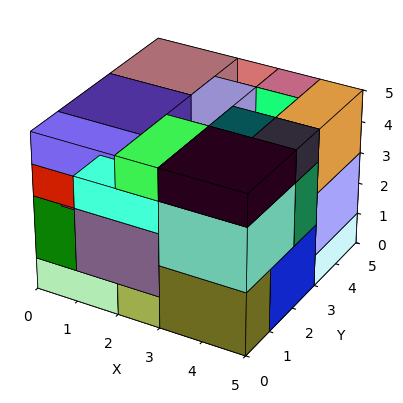


MLP episode (seed 0)


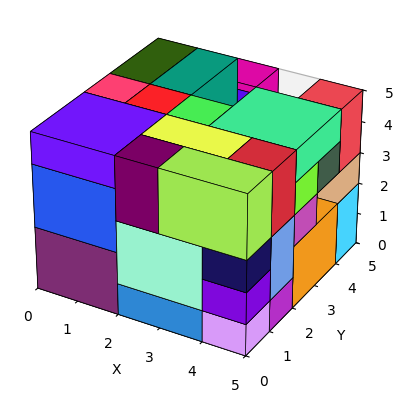

123

In [58]:

# Render one episode for each policy
print('Greedy episode (seed 0)')
run_episode(greedy_policy, env_seed=0, render=True)

print('\nMLP episode (seed 0)')
run_episode(mlp_policy, env_seed=0, render=True)


SyntaxError: unexpected character after line continuation character (2823941216.py, line 1)